In [1]:
%matplotlib inline


# Generate Images

This ipython notebook demonstrates how to generate an image dataset with rich
ground truth from a virtual environment.

In [2]:
import time; print(time.strftime("The last update of this file: %Y-%m-%d %H:%M:%S", time.gmtime()))

The last update of this file: 2025-06-18 23:46:17


Load some python libraries
The dependencies for this tutorials are
PIL, Numpy, Matplotlib



In [3]:
from __future__ import division, absolute_import, print_function
import os, sys, time, re, json
import numpy as np
import matplotlib.pyplot as plt

imread = plt.imread
#读取图像文件并保存为8bit的numpy数组
def imread8(im_file):
    ''' Read image as a 8-bit numpy array '''
    im = np.asarray(Image.open(im_file))
    return im

# def read_png(res):
#     import StringIO, PIL.Image
#     img = PIL.Image.open(StringIO.StringIO(res))
#     return np.asarray(img)
#从字节流（res）中读取 PNG 图像，并将其转换为 NumPy 数组
def read_png(res):
    import io
    from PIL import Image
    img = Image.open(io.BytesIO(res))
    return np.asarray(img)

# def read_npy(res):
#     import StringIO
#     return np.load(StringIO.StringIO(res))
#从字节流（res）中读取 .npy 格式的 NumPy 数据。
def read_npy(res):
    import io
    return np.load(io.BytesIO(res))

## Connect to the game

Load unrealcv python client, do `pip install unrealcv` first.



In [4]:
from unrealcv import Client
import sys
client = Client(('localhost', 9000))
client.connect()
if not client.isconnected():
    print('UnrealCV server is not running. Run the game downloaded from http://unrealcv.github.io first.')
    sys.exit(-1)

e:\Software\Anaconda\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
e:\Software\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
e:\Software\Anaconda\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
INFO:__init__:232:Got connection confirm: b'connected to test52'


=>Info: using ip-port socket


Make sure the connection works well



In [5]:
res = client.request('vget /unrealcv/status')
# The image resolution and port is configured in the config file.
print(res)

Is Listening
Client Connected
9000
Configuration
Config file: E:/Software/Epic Games/UE_5.2/Engine/Binaries/Win64/unrealcv.ini
Port: 9000
Width: 640
Height: 480
FOV: 90.000000
EnableInput: true
EnableRightEye: false



## Load a camera trajectory

In [6]:
traj_file = './camera_traj.json' # Relative to this python script
import json; camera_trajectory = json.load(open(traj_file))
# We will show how to record a camera trajectory in another tutorial

## Render an image

The image is saved to: lit.png
The image is saved to lit.png in the current directory.
(480, 640, 4)


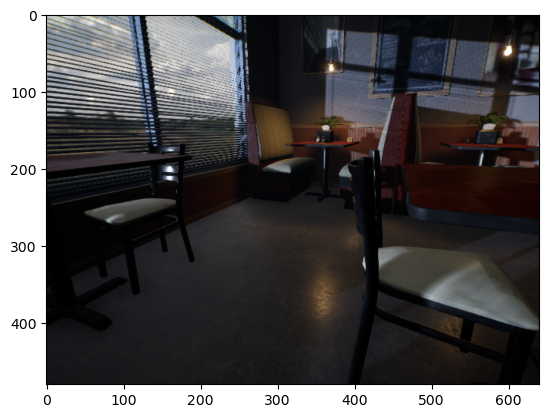

In [7]:
idx = 4
loc, rot = camera_trajectory[idx]
# Set position of the first camera
client.request('vset /camera/1/location {x} {y} {z}'.format(**loc))
client.request('vset /camera/1/rotation {pitch} {yaw} {roll}'.format(**rot))
# player_controller_name = "PlayerController_0" # Common default
# pawn_name = "PawnCamSensor" # The actor PawnSamSensor is attached to

# cmd = f"vbp {player_controller_name} SetViewTargetWithBlend {pawn_name} 0.0 NONE 0.0 false"
# client.request(cmd)
# Get image
res = client.request('vget /camera/1/lit lit.png')
print(f"The image is saved to: {res}")

# It is also possible to get the png directly without saving to a file
res = client.request('vget /camera/1/lit png')
with open('lit.png', 'wb') as f:
    f.write(res)
print("The image is saved to lit.png in the current directory.")
im = read_png(res)
print(im.shape)

# Visualize the image we just captured
plt.imshow(im)
plt.show()

## Ground truth generation

Generate ground truth from this virtual scene



normal shape: (480, 640, 4)
max: 255 min: 0 mean: 143.75118733723957


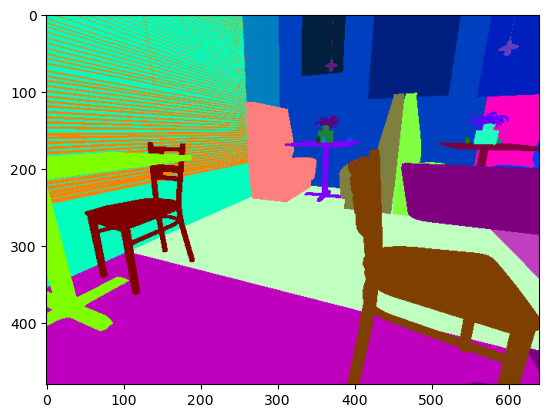

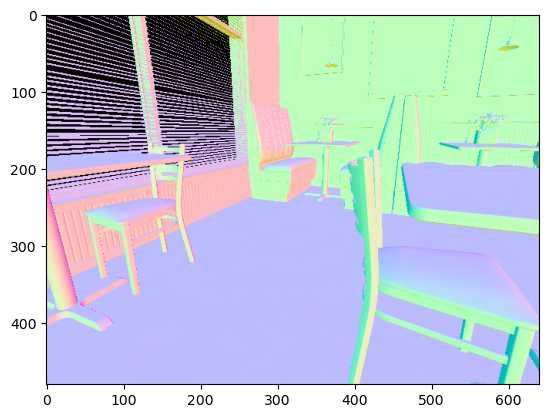

In [9]:
res = client.request('vget /camera/1/object_mask png')
object_mask = read_png(res)
res = client.request('vget /camera/1/normal png')
normal = read_png(res)
print("normal shape:", normal.shape)
print("max:", normal.max(), "min:", normal.min(), "mean:", normal.mean())
normal_rgb = normal[:, :, :3]
# Visualize the captured ground truth
plt.imshow(object_mask)
plt.figure()
plt.imshow(normal_rgb)
plt.show()
import matplotlib.pyplot as plt
plt.imsave('normal_saved.png', normal_rgb)

Depth is retrieved as a numpy array
For UnrealCV < v0.3.8, the depth is saved as an exr file, but this has two issues. 1. Exr is not well supported in Linux 2. It depends on OpenCV to read exr file, which is hard to install



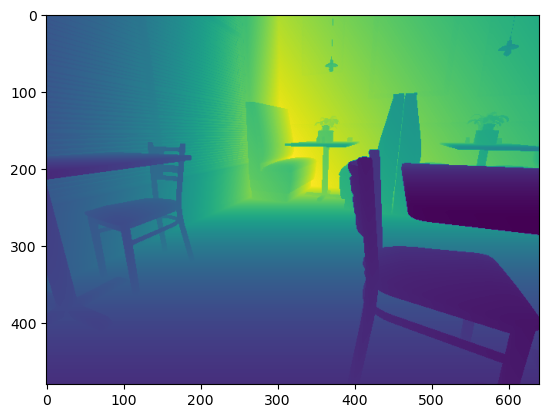

In [10]:
res = client.request('vget /camera/1/depth npy')
depth = read_npy(res)
plt.imshow(depth)
plt.show()

## Get object information

List all the objects of this virtual scene



In [22]:
# 先看原始返回内容
raw_response = client.request('vget /objects')
print("Raw response:")
print(repr(raw_response))
print()

# 再看split()后的结果
scene_objects = raw_response.split()
print("After split():")
for obj in scene_objects:
    print(obj)
    print()

Raw response:
'ChaosDebugDrawActor GameplayDebuggerCategoryReplicator_0 GameplayDebuggerPlayerManager_0 Brush_0 Seq01 Seq02 Seq03 Seq04 Seq05 Seq06 SequenceMaster Seq07 Cube_66 Cube2 Cube3 Cube4 Cube5 Cube6 Sphere_77 Cube7 Blinds_SM_VenetianBlind_Close_2 Blinds_SM_VenetianBlind_Open_5 BoothsChairsTables_SM_Booth_Single_4 BoothsChairsTables_SM_Chair_6 BoothsChairsTables_SM_Table_8 BoothsChairsTables_SM_Table2 BoothsChairsTables_SM_Chair2 SeatsAndTables_SM_Table7 SeatsAndTables_SM_Table8 SeatsAndTables_SM_Table17 SeatsAndTables_SM_Table16 SeatsAndTables_SM_Table10 SeatsAndTables_SM_Table9 SeatsAndTables_SM_Table19 SeatsAndTables_SM_Table18 SeatsAndTables_SM_Table6 SeatsAndTables_SM_Table5 SeatsAndTables_SM_Table4 SeatsAndTables_SM_Table2 BoothsChairsTables_SM_Booth_Single2 BoothsChairsTables_SM_Booth_Single3 BoothsChairsTables_SM_Booth_Single4 BoothsChairsTables_SM_Booth_Single5 BoothsChairsTables_SM_Booth_Single6 BoothsChairsTables_SM_Booth_Single7 BoothsChairsTables_SM_Booth_Single8 Se

In [12]:

#scene_objects = client.request('vget /objects').split(' ')
scene_objects = client.request('vget /objects').split()
print('Number of objects in this scene:', len(scene_objects))

# TODO: replace this with a better implementation
class Color(object):
    ''' A utility class to parse color value '''
    regexp = re.compile(r'\(R=(.*),G=(.*),B=(.*),A=(.*)\)')
    def __init__(self, color_str):
        self.color_str = color_str
        match = self.regexp.match(color_str)
        (self.R, self.G, self.B, self.A) = [int(match.group(i)) for i in range(1,5)]

    def __repr__(self):
        return self.color_str

id2color = {} # Map from object id to the labeling color
for obj_id in scene_objects:
    #color = Color(client.request('vget /object/%s/color' % obj_id))
    # id2color[obj_id] = color
    # print('%s : %s' % (obj_id, str(color)))
    #adding error handling for NoneType returns
    color_response = client.request('vget /object/%s/color' % obj_id)
    try:
        color = Color(color_response)
        id2color[obj_id] = color
        print('%s : %s' % (obj_id, str(color)))
    except (AttributeError, ValueError) as e:
        # 打印出失败的对象和具体的错误信息
        print(f"    [ERROR] !!! Failed to process object '{obj_id}'. Reason: {e}")
        continue


Number of objects in this scene: 443
ChaosDebugDrawActor : (R=0,G=0,B=0,A=0)
GameplayDebuggerCategoryReplicator_0 : (R=0,G=0,B=0,A=0)
GameplayDebuggerPlayerManager_0 : (R=0,G=0,B=0,A=0)
Brush_0 : (R=0,G=0,B=0,A=0)
Seq01 : (R=0,G=0,B=0,A=0)
Seq02 : (R=0,G=0,B=0,A=0)
Seq03 : (R=0,G=0,B=0,A=0)
Seq04 : (R=0,G=0,B=0,A=0)
Seq05 : (R=0,G=0,B=0,A=0)
Seq06 : (R=0,G=0,B=0,A=0)
SequenceMaster : (R=0,G=0,B=0,A=0)
Seq07 : (R=0,G=0,B=0,A=0)
Cube_66 : (R=0,G=255,B=255,A=255)
Cube2 : (R=255,G=0,B=0,A=255)
Cube3 : (R=255,G=0,B=255,A=255)
Cube4 : (R=255,G=255,B=0,A=255)
Cube5 : (R=255,G=255,B=255,A=255)
Cube6 : (R=0,G=255,B=127,A=255)
Sphere_77 : (R=255,G=0,B=127,A=255)
Cube7 : (R=0,G=127,B=0,A=255)
Blinds_SM_VenetianBlind_Close_2 : (R=0,G=127,B=255,A=255)
Blinds_SM_VenetianBlind_Open_5 : (R=255,G=127,B=0,A=255)
BoothsChairsTables_SM_Booth_Single_4 : (R=255,G=127,B=127,A=255)
BoothsChairsTables_SM_Chair_6 : (R=127,G=0,B=0,A=255)
BoothsChairsTables_SM_Table_8 : (R=127,G=0,B=255,A=255)
BoothsChairsTables_

Parse the segmentation mask



In [13]:
def match_color(object_mask, target_color, tolerance=10):
    match_region = np.ones(object_mask.shape[0:2], dtype=bool)
    for c in range(3): # r,g,b
        min_val = target_color[c] - tolerance
        max_val = target_color[c] + tolerance
        channel_region = (object_mask[:,:,c] >= min_val) & (object_mask[:,:,c] <= max_val)
        match_region &= channel_region

    if match_region.sum() != 0:
        return match_region
    else:
        return None

id2mask = {}
# 只遍历那些在id2color中实际存在的对象，避免KeyError
for obj_id in id2color.keys():
    color = id2color[obj_id]
    mask = match_color(object_mask, [color.R, color.G, color.B], tolerance = 10)
    if mask is not None:
        id2mask[obj_id] = mask
        print(f'{obj_id} : Mask created')
    else:
        print(f'{obj_id} : No mask created, color not found in the object mask')

print(f'Successfully created masks for {len(id2mask)} objects')
# This may take a while
# TODO: Need to find a faster implementation for this

ChaosDebugDrawActor : No mask created, color not found in the object mask
GameplayDebuggerCategoryReplicator_0 : No mask created, color not found in the object mask
GameplayDebuggerPlayerManager_0 : No mask created, color not found in the object mask
Brush_0 : No mask created, color not found in the object mask
Seq01 : No mask created, color not found in the object mask
Seq02 : No mask created, color not found in the object mask
Seq03 : No mask created, color not found in the object mask
Seq04 : No mask created, color not found in the object mask
Seq05 : No mask created, color not found in the object mask
Seq06 : No mask created, color not found in the object mask
SequenceMaster : No mask created, color not found in the object mask
Seq07 : No mask created, color not found in the object mask
Cube_66 : No mask created, color not found in the object mask
Cube2 : No mask created, color not found in the object mask
Cube3 : No mask created, color not found in the object mask
Cube4 : No mask 

## Print statistics of this virtual scene and this image

Load information of this scene

In [14]:
with open('object_category.json') as f:
    id2category = json.load(f)
categories = set(id2category.values())
# Show statistics of this frame
image_objects = id2mask.keys()
print('Number of objects in this image:', len(image_objects))
print('%20s : %s' % ('Category name', 'Object name'))
for category in categories:
    objects = [v for v in image_objects if id2category.get(v) == category]
    if len(objects) > 6: # Trim the list if too long
        objects[6:] = ['...']
    if len(objects) != 0:
        print('%20s : %s' % (category, objects))

Number of objects in this image: 33
       Category name : Object name
  BoothsChairsTables : ['BoothsChairsTables_SM_Booth_Single_4', 'BoothsChairsTables_SM_Chair_6', 'BoothsChairsTables_SM_Table_8', 'BoothsChairsTables_SM_Table2', 'BoothsChairsTables_SM_Booth_Single2', 'BoothsChairsTables_SM_Booth_Single3', '...']
               Props : ['WallProps_SM_Chalkboard_6', 'WallProps_SM_WallPainting_2', 'WallProps_SM_WallPainting_1', 'Props_SM_NapkinDispenser4', 'Props_SM_Shaker_Pepper4', 'Props_SM_Shaker_Salt4', '...']
        StaticMeshes : ['Blinds_SM_VenetianBlind_Open_5', 'SM_PlantPot5', 'SM_PlantPot6', 'SM_CeilingLamp_2', 'SM_CeilingLamp12_35']
      SeatsAndTables : ['SeatsAndTables_SM_Table7', 'SeatsAndTables_SM_Table2', 'SeatsAndTables_SM_Chair3']
      WallsAndFloors : ['WallsAndFloors_SM_Wall_Windows_3m_9', 'Walls_SM_Wall_3x4m_118', 'Walls_SM_Wall_3x4m2', 'Walls_SM_Wall_3x4m3', 'WallsAndFloors_SM_FloorCeiling_3x3m23', 'WallsAndFloors_SM_FloorCeiling_3x3m24', '...']


Show the annotation color of some objects



In [15]:
ids = ['BoothsChairsTables_SM_Table2', 'SeatsAndTables_SM_Chair3', 'BoothsChairsTables_SM_Booth_Single_2', 'SM_Plant_8']
# for obj_id in ids:
obj_id = ids[0]
color = id2color[obj_id]
print('%s : %s' % (obj_id, str(color)))
# color_block = np.zeros((100,100, 3)) + np.array([color.R, color.G, color.B]) / 255.0
# plt.figure(); plt.imshow(color_block); plt.title(obj_id)

BoothsChairsTables_SM_Table2 : (R=127,G=255,B=0,A=255)


Plot only one object



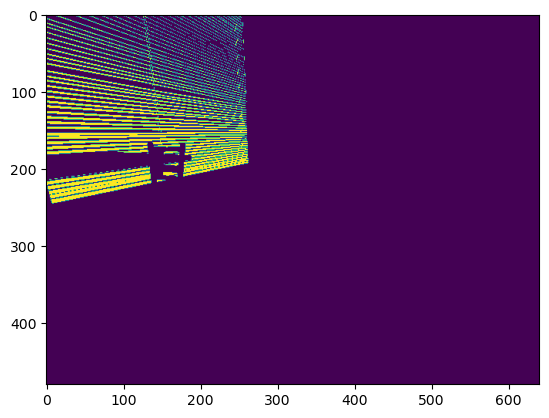

In [21]:
mask = id2mask['Blinds_SM_VenetianBlind_Open_5']
plt.figure(); plt.imshow(mask)
plt.show()

Show all sofas in this image



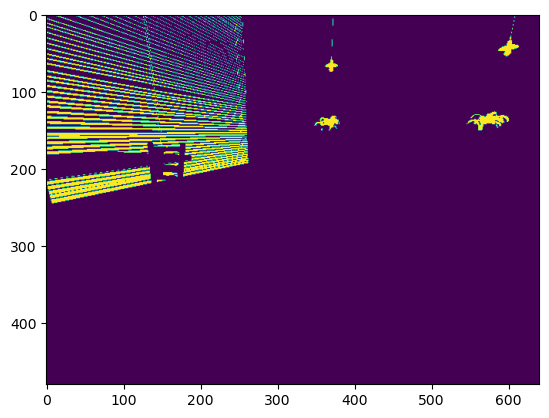

In [22]:
couch_instance = [v for v in image_objects if id2category.get(v) == 'StaticMeshes']
#couch_instance = [v for v in image_objects if id2category.get(v) == 'SeatsAndTables']

mask = sum(id2mask[v] for v in couch_instance)
plt.figure(); plt.imshow(mask);plt.show()

Change the annotation color, fixed in v0.3.9
You can use this to make objects you don't care the same color



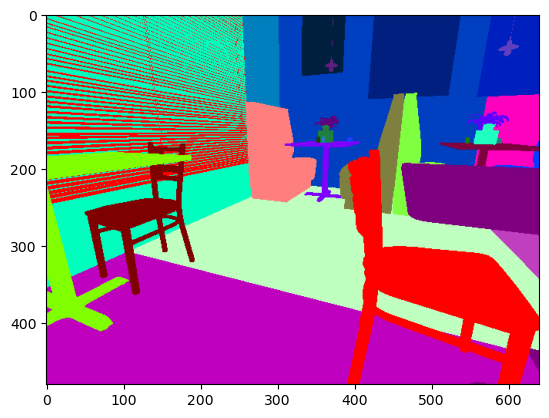

In [25]:
client.request('vset /object/Blinds_SM_VenetianBlind_Open_5/color 255 0 0') # Change to pure red
client.request('vget /object/StaticMBlinds_SM_VenetianBlind_Open_5eshes/color')
res = client.request('vget /camera/1/object_mask png')
object_mask = read_png(res)
plt.imshow(object_mask)
plt.show()

2D Bounding Box (pixels): xmin=0, ymin=0, xmax=262, ymax=245


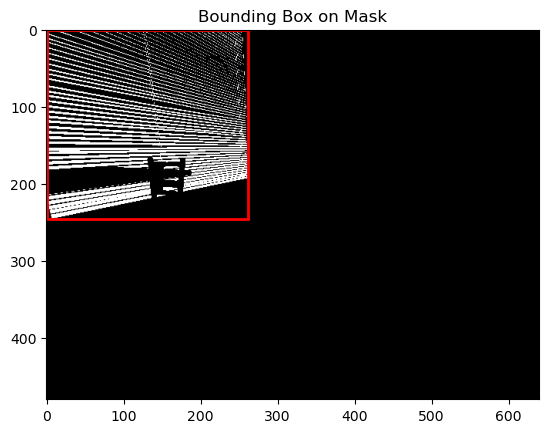

In [26]:
import numpy as np

# 从现有 id2mask 拿到 mask
mask = id2mask['Blinds_SM_VenetianBlind_Open_5']

# 找到 mask 中所有 True 的像素坐标
ys, xs = np.where(mask)

# 如果 mask 为空则避免报错
if len(xs) == 0 or len(ys) == 0:
    print("Mask is empty, cannot compute bounding box.")
else:
    xmin, xmax = xs.min(), xs.max()
    ymin, ymax = ys.min(), ys.max()
    print(f"2D Bounding Box (pixels): xmin={xmin}, ymin={ymin}, xmax={xmax}, ymax={ymax}")

    # 可选: 画一下
    import matplotlib.pyplot as plt
    plt.imshow(mask, cmap='gray')
    plt.gca().add_patch(
        plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                      edgecolor='red', facecolor='none', lw=2)
    )
    plt.title('Bounding Box on Mask')
    plt.show()


## Clean up resources

In [27]:
from unrealcv import Client
client = Client(('localhost', 9000))
client.disconnect()